<h1> 1 Data analysis with sinusoid of unknown amplitude in known Gaussian noise</h1>

<p class='lead'>
    The problem you are faced with is detecting and characterizing a sinusoid
    in Gaussian noise.  This is a standard 
    and simple problem in data analysis that will give you a flavor of the data
    analysis problems and techniques used in real PTA data analysis. In fact, 
    nearly the entire GW detection problem is framed in this way: Is there a
    detectable GW (be it stochastic, continuous, or burst) present in the puslar
    timing residual data? The challenge is coming up with robust and efficient 
    analysis methods that take into account all of the intracacies of real puslar
    timing data.
    <br/><br/>
    Dealing with real or simulated PTA data will only cause additional complications
    and will deter you from learning the basics of data analysis. In this activity 
    you will explore both frequentist and Bayesian techniques for parameter estimation, 
    detection, and setting upper limits. <br/><br/>
    We assume that the data $d$ is composed of a signal $s$ plus additive white gaussian 
    noise $n$, that is
    $$
    d=s+n.
    $$
    Since $n$ is assumed to be white and Gaussian, its probability distribution is a product of
    Gaussians
    $$
    p(n)=\frac{1}{\sqrt{2 \pi \sigma^2}}\prod_i\exp\left(-\frac{n_i^2}{2\sigma^2}\right),
    $$
    where $n_i$ is the noise at time $t_i$ and $\sigma$ is the standard deviation of the noise. 
    We can now write this in terms of the data using $n=d-s$, therefore the likelihood function
    for the data given the signal parameters, $\lambda$ is
    $$
    p(d|\lambda)=\frac{1}{\sqrt{2 \pi \sigma^2}}\prod_i\exp\left(-\frac{(d_i-s_i(\lambda))^2}{2\sigma^2}\right).
    $$
    For our purposes we will deal with the natural log of the likelihood ratio. The likelihood ratio is the 
    likelihood function above divided by the likelihood that the signal is pure noise (i.e, remove
    the signal $s$ from the model). We will also introduce a new notation and write the log-likelihood 
    ratio
    $$
    \log\Lambda=(d|s)-\frac{1}{2}(s|s),
    $$
    where the inner product of two timeseries $x$ and $y$, for example, is $(x|y)=\sum_i x_iy_i/\sigma^2$.
    In our case the signal $s$ is just a sinusoid, $s(t,A,f) = A\sin(2\pi ft)$. For simplicity we will 
    assume that we know the frequency (or that we are doing a "target" search for a certain frequency) 
    of the sinusoid and the only unknown parameter is the amplitude.
    <br/><br/>
    Your first exercise will be to create a simulated dataset with white noise and a small sinusoid. 
    <br/><br/>
    Good luck!

</p>

In [81]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import worksheet_utils as wu
from scipy.interpolate import interp1d
import simple_mcmc as smcmc
from corner import corner
import nestle

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

<h2>1.0. Derving the log-likelihod ratio</h2>

<p class='lead'>
    Above we have written down the log of the likehood ratio which will be used throughout this 
    entire worksheet. To get yourself familiar with the notation, derive the log-likelihood ratio
    defined above. 
    <br/><br/>
    <em>Hint</em>: It will be easier to take the logarithm of each likelihood function first and
    then take the difference (i.e., $\log(A/B)-\log(A)-\log(B)$).
</p>

<h2>1.1 Simulating the data set. </h2>

<p class='lead'>
    Create a 5 year timeseries of 130 points using `numpy` function <strong>`linspace()`</strong> beginning at 0. 
    Then, use the <strong>`simData()`</strong> function from `worksheet_utils` to simulate some fake data with a standard devitaion of 
    100 ns and a signal with amplitude 70 ns and frequency of $10^{-8}$ Hz.
    <br/><br/>
    Then use the `matplotlib` function __`plot()`__ to plot the data vs. time and be sure to label the axes. Next, create a separate dataset with no noise by calling the __`signal()`__ function from `worksheet_utils` in order to plot just the signal on top of the signal+noise dataset.
</p>

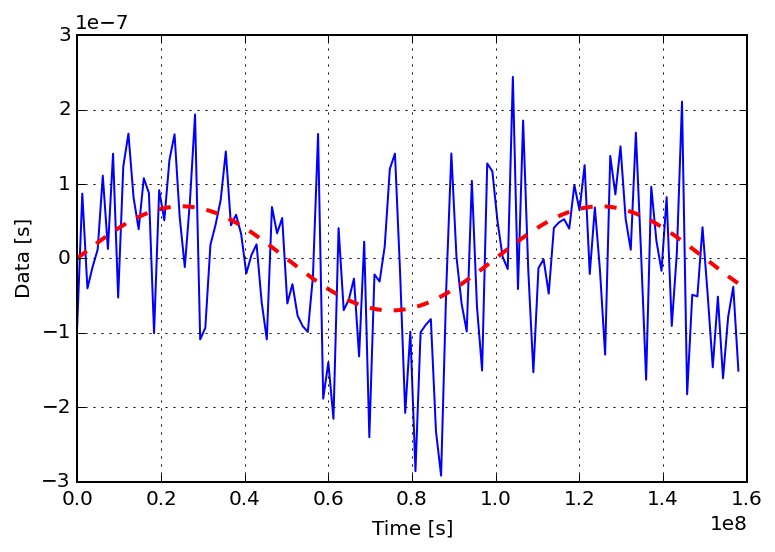

In [2]:
# simulated data
freq = 1e-8
sigma = 1e-7
t = np.linspace(0, 3.16e7*5, 130)
A = 7e-8

# call function to simulate data
data = wu.simData(t, A, freq, sigma)

# can also get signal individually
sig = wu.signal(t, A, freq)

# plot
plt.plot(t, data)
plt.plot(t, sig, lw=2, color='r', ls='--')
plt.xlabel('Time [s]')
plt.ylabel('Data [s]')
plt.grid()

<h2>1.2 Parameter Estimation: Estimating the Amplitude</h2>

<p class='lead'>
    In frequentist statistics, one is interested in defining some estimator for the true signal parameters.
    A common way to do this is to find the parameters that maximize the likelihood. These are known as Maximum
    Likelihood Estimators (MLEs). One can then place confidence intervals on the parameter of interest through the 
    <em>Neyman method</em>: define some statistic $x$ that is a function of the data $d$ (for example the MLE of the
    unknown signal parameters). Because $x$ is derived from $d$, the probability distribution (likelihood) $p(d|\lambda)$
    can be re-expressed as a probability distribution $p(x|\lambda)$. Then, for each value of $\lambda$, we produce an 
    interval $(x_1,x_2)$ such that
    $$
    \alpha = \int_{x_1}^{x_2}dx\,\, p(x|\lambda)
    $$
    The intervals that depend on $\lambda$ define a belt in the $\lambda-x$ plane and for any <em>observed</em> value
    of $x$ in the experiment, the confidence interval on $\lambda$ constitutes the values of $\lambda$ that exist on the 
    belt at that fixed value of $x$. (See additional handout for more details)
    <br/><br/>
    In Bayesian statistics, one is interested finding the probability distribution function for the unknown parameters given
    that we have some observed data. To get a point estimate of the unkwnown parameters we may use the <em>maximum a-posteriori</em>
    (MAP) parameters, that is, the maximum of the posterior probability distribution. A credible interval (Bayesian version
    of confidence intervals) can be constructed directly from the posterior distribution $p(\lambda|d)$ as
    $$
    \alpha = \int_{\lambda_1}^{\lambda_2}d\lambda\,\, p(\lambda|d),
    $$
    where $\lambda_1$ and $\lambda_2$ defined the lower and upper bounds on our parameter $\lambda$.
</p>

<h3>1.2.1 MLE for the amplitude</h3>

<p class='lead'>
    As written above, the log-likelihood ratio is 
    $$
    \log\Lambda=(d|s)-\frac{1}{2}(s|s).
    $$
    If we let $s(t)=A\sin(2\pi f t)$ and $\tilde{s}(t)=\sin(2\pi f t)$, then $s(t)=A\tilde{s}(t)$. 
    Re-writing the log-likehood ratio, we obtain
    $$
    \log\Lambda=A(d|\tilde{s})-\frac{A^2}{2}(\tilde{s}|\tilde{s}).
    $$
    We can now maximize the likehood function over the unknown amplitude, $A$, as follows
    $$
    0 = \frac{\partial \log\Lambda}{\partial A} = (d|\tilde{s}) -\hat{A}(\tilde{s}|\tilde{s}),
    $$
    where $\hat{A}$ is the MLE for $A$. Solving for $\hat{A}$, we obtain
    $$
    \hat{A}=\frac{(d|\tilde{s})}{(\tilde{s}|\tilde{s})}.
    $$
    The variance on the maximum likelihood estimator is then
    $$
    \sigma_{\hat{A}}^2 = \langle \hat{A}\hat{A} \rangle -\langle \hat{A} \rangle^2 = \frac{1}{(\tilde{s}|\tilde{s})},
    $$
    where $\langle  \rangle$ denotes the <em>expectation value</em> or average over many realizations of data.
<ol>
    <li class='lead'>
        Write a function that reads in the data, the time samples, the frequency of the sine wave and the 
        standard deviation of the noise as arguments and outputs the MLE and standard deviation of $A$. 
        <em>Hint:</em> Look at the `worksheet_utils` package to figure out what functions you may need.<br/>
        <span style="color:red">For intermediate/expert level: Derive the variance of $\hat{A}$. <em>Hint:</em> 
        $\langle (n|\tilde{s}) \rangle=0$ and $\langle (n|\tilde{s})(n|\tilde{s}) \rangle=(\tilde{s}|\tilde{s})$.</span>
    </li>
    <li class='lead'>
        Use this function to compute $\hat{A}$ for our simulated data set.
    </li>   
    <li class='lead'>Does the answer you get make sense? What is the percent error?</li>
</ol>
</p>   

In [3]:
#  maximum likelihood estimator for A
def maxLikeA(data, t, f, sigma):
    sig = wu.signal(t, 1, f)
    return wu.innerProduct(data, sig, sigma)/wu.innerProduct(sig, sig, sigma), np.sqrt(1/wu.innerProduct(sig, sig, sigma))

In [4]:
Ahat, stdAhat = maxLikeA(data, t, freq, sigma)
print 'MLE for A = {0} +/ {1}'.format(Ahat, stdAhat)
print 'True value of A = {0}'.format(A)

MLE for A = 6.58763445893e-08 +/ 1.27124648726e-08
True value of A = 7e-08


<h3>1.2.2 Posterior distribution for the amplitude</h3>

<ol class = 'lead'>
    <li>
        Write a function that reads in the data, the time samples, the amplitude of the sine wave, the frequency of the sine wave
        and the standard deviation of the noise and returns the log-likelihood ratio.
    </li>
    <li>
        Create a vector of trial amplitudes in the range $[0, 5\times 10^{-7}]$ with length 1000 using
        the __`np.linspace()`__ function. You can play around with the length of the array and the ranges
        once you have done this once.
    </li>    
    <li>
        Loop over these amplitudes and compute the log-posterior for each one and store
        it in an array. Here we will use a uniform prior on $A$ which means that the likelihood
        and the posterior are identical except for a normalizing constant which is not important 
        here. The posterior is then
        $$
        \log\,p(A|d) \propto \log\Lambda(d|A) + \log p(A),
        $$
        where p(A) is the prior. 
    </li>
    <li>
        This prior must be normalized to 1, so if our prior is uniform in $A$ then
        it is the save for every value of $A$, thus $p(A)=C$, where $C$ is a constant. 
        Integrate this uniform prior to determine
        the normalization constant (i.e., use $\int p(A)dA=1$ to find the value of $C$).
    </li>   
    <li>
        Use the __`plt.plot()`__ function to plot the posterior vs. the 
        Amplitude Array.
    </li>    
    <li>
        Determine the MAP value of $A$ by using the __`np.argmax()`__ function to find the array index
        of the maximum posterior value. You can then use this array index to find the corresponding
        value of $A$ from the vector of trial amplitudes that you created in step 2.
    </li>    
    <li>
        Determine the standard deviation of $A$. <em>Hint:</em> recall that the statistical definition
        of variance on a parameter $x$ whose pdf is $p(x)$ is $\sigma^2_x=\langle x^2 \rangle - \langle x \rangle^2 
        = \int dx \, x^2\,p(x) - \left(\int dx\, x\, p(x)\right)^2$
    </li>    
    <li>
        Plot the likelihood vs $A$. Plot a vertical line denoting the true value of $A$ with the __`plt.axvline()`__ 
        function. Also, use the __`plt.axvspan()`__ with the <em>alpha</em> argument to plot a shaded region denoting
        the standard deviation of $A$.
    </li>
</ol>
    

In [5]:
# likelihood function
def LogLikelihood(data, t, A, f, sigma):
    sig = wu.signal(t, A, f)
    return wu.innerProduct(data, sig, sigma) - 0.5 * wu.innerProduct(sig, sig, sigma)

MAP value for A = 6.60660660661e-08 +/ 1.27124473318e-08
True value of A = 7e-08


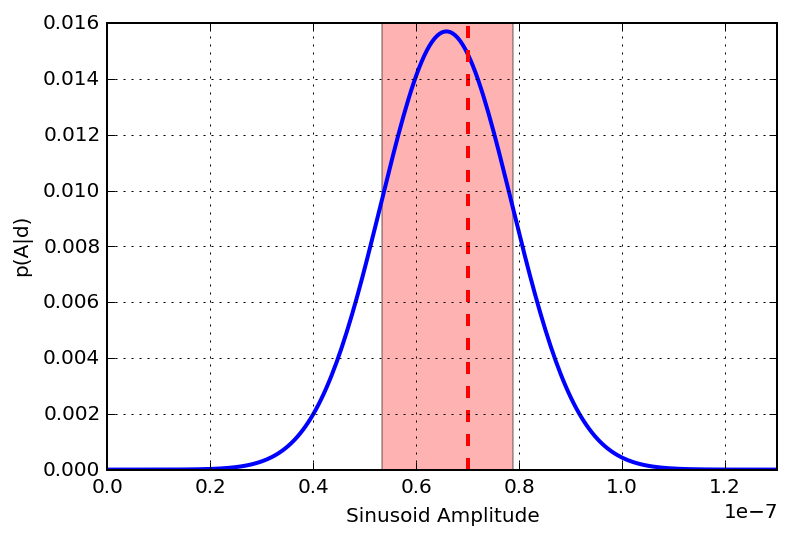

In [6]:
N = 1000
Amps = np.linspace(0, 5e-7, N)
llike = np.zeros(N)
for ii in range(N):
    llike[ii] = LogLikelihood(data, t, Amps[ii], freq, sigma)

post = np.exp(llike) / (Amps.max()-Amps.min())  
mapA = Amps[np.argmax(post)]
p = post/post.sum()
stdA = np.sqrt(np.sum(Amps**2*p) - np.sum(Amps*p)**2)
print 'MAP value for A = {0} +/ {1}'.format(mapA, stdA)
print 'True value of A = {0}'.format(A)

plt.plot(Amps, p, lw=2)
plt.axvline(A, color='r', lw=2, ls='--')
plt.axvspan(mapA-stdA,mapA+stdA, facecolor='r',alpha=0.3)
plt.grid()
plt.xlim(0, 1.3e-7)
plt.xlabel('Sinusoid Amplitude')
plt.ylabel('p(A|d)')

<h4 class='lead'>1.2.2.1: Gaussian prior distribution on $A$</h4>

<p class='lead'>
    It is often the case in data analysis where we have some additional prior information about our problem before
    conducting the experiment. In the Bayesian framework we incorporate this additional information into the prior
    probability distribution. The data (via the likelihood function) is then used to update our prior knowledge. If
    our data is <em>informative</em> then the posterior distribution will be different then the prior distribution. 
    On the other hand, if our posterior results in distribution that is identical to the prior then our data is not
    informative.
    <br/><br/>
    To illustrate this, we will assume that through some other experiment, or from some theoretical prediction, we have
    some prior knowledge of the amplitude of the sine wave in our data. We will model this as a gaussian prior with the
    mean the true value that we used to create the data and some standard deviation
    $$
    p(A)=\frac{1}{\sqrt{2\pi\sigma_A^2}}\exp\left(-\frac{(A-A_{\rm true})^2}{2\sigma_A^2}\right)
    $$
</p>

<ol class='lead'>
    <li>
        Let the fractional uncertainty on $A$ be 25%, that is $\sigma_A=0.25\times A$. Use this information in the
        gaussian prior and repeat the steps from exercise 2.2. You will need to create an extra array to store the 
        prior function when conducting the for loop. When constructing the posterior, remember to  multiply the 
        likelihood by the prior.
    </li>
    <li>
        Make sure that the posterior and prior both are both normalized and plot the posterior and the prior vs. A.
        Is the data informative?
    </li>
    <li>
        Repeat this exercise for $\sigma_A=0.05\times A$.
    </li>
</ol>

MAP value for A = 6.65665665666e-08 +/ 1.13079106764e-08
True value of A = 7e-08


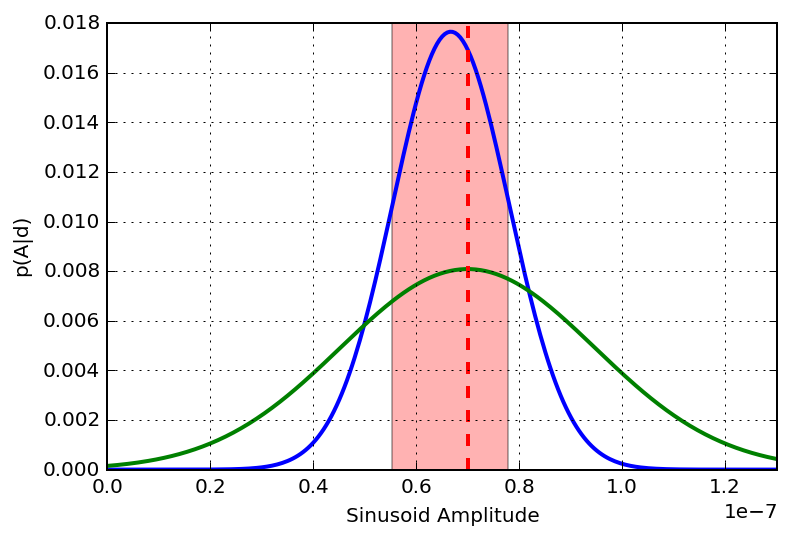

In [7]:
N = 1000
Amps = np.linspace(0, 5e-7, N)
llike2 = np.zeros(N)
logpr2 = np.zeros(N)
sigma_A = A * 0.25
for ii in range(N):
    llike2[ii] = LogLikelihood(data, t, Amps[ii], freq, sigma) 
    logpr2[ii] = - 0.5*(np.log(2*np.pi*sigma_A**2) + (Amps[ii]-A)**2/2/sigma_A**2)

post2 = np.exp(llike2+logpr2)  
mapA = Amps[np.argmax(post2)]
p2 = post2/post2.sum()
pr = np.exp(logpr2)
pr /= pr.sum()
stdA = np.sqrt(np.sum(Amps**2*p2) - np.sum(Amps*p2)**2)
print 'MAP value for A = {0} +/ {1}'.format(mapA, stdA)
print 'True value of A = {0}'.format(A)

plt.plot(Amps, p2, lw=2)
plt.plot(Amps, pr, lw=2, color='g')

plt.axvline(A, color='r', lw=2, ls='--')
plt.axvspan(mapA-stdA,mapA+stdA, facecolor='r',alpha=0.3)
plt.grid()
plt.xlim(0, 1.3e-7)
plt.xlabel('Sinusoid Amplitude')
plt.ylabel('p(A|d)')

MAP value for A = 6.95695695696e-08 +/ 4.61245062512e-09
True value of A = 7e-08


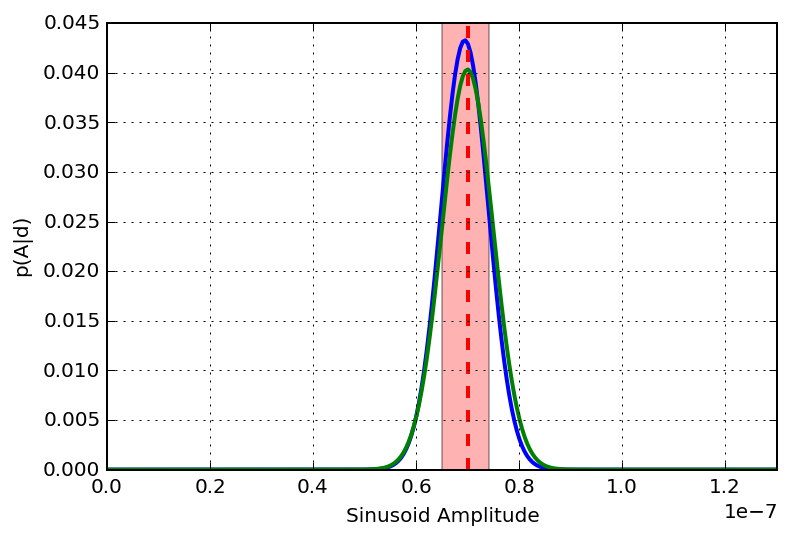

In [8]:
N = 1000
Amps = np.linspace(0, 5e-7, N)
llike2 = np.zeros(N)
logpr2 = np.zeros(N)
sigma_A = A * 0.05
for ii in range(N):
    llike2[ii] = LogLikelihood(data, t, Amps[ii], freq, sigma) 
    logpr2[ii] = - 0.5*(np.log(2*np.pi*sigma_A**2) + (Amps[ii]-A)**2/2/sigma_A**2)

post2 = np.exp(llike2+logpr2)  
mapA = Amps[np.argmax(post2)]
p2 = post2/post2.sum()
pr = np.exp(logpr2)
pr /= pr.sum()
stdA = np.sqrt(np.sum(Amps**2*p2) - np.sum(Amps*p2)**2)
print 'MAP value for A = {0} +/ {1}'.format(mapA, stdA)
print 'True value of A = {0}'.format(A)

plt.plot(Amps, p2, lw=2)
plt.plot(Amps, pr, lw=2, color='g')

plt.axvline(A, color='r', lw=2, ls='--')
plt.axvspan(mapA-stdA,mapA+stdA, facecolor='r',alpha=0.3)
plt.grid()
plt.xlim(0, 1.3e-7)
plt.xlabel('Sinusoid Amplitude')
plt.ylabel('p(A|d)')

<h3>1.2.3 Frequentist Confidence Interval on Amplitude Parameter</h3>

<p class='lead'>
    As we show above, contructing a frequentist confidence interval involves simulating several realizations of data with different values of the sinusoid amplitude. Here we will construct a function to do just that.
</p>

<ol class='lead'>
    <li>
        Create a vector of trial amplitudes in the range $[1\times 10^{-8}, 3\times 10^{-7}]$ with length 100 using
        the __`linspace()`__ function.
    </li>    
    <li>
        Loop over these amplitudes as above but now add a second inner loop to simulate different <em>
        realizations</em> of the data. Use __`simData()`__ function to simulate the new data. For each
        amplitude do 1000 realizations of data with that amplitude. (See code block below for hints)
    </li>    
    <li>
        The goal here is to compute the MLE for $A$ for each realization of data. For a given amplitude,
        compute $\hat{A}$ for each data realization using your function from exercise 2.1 and store it in an
        array. Then use the __`confinterval()`__ function from `worksheet_utils` to define the upper and lower 1-sigma bounds on the
        distribution of $\hat{A}$ for a given value of $A$. Store these 1-sigma lower and upper
        bounds in arrays. This will create the band through the $A$-$\hat{A}$ space as we saw in the
        talk. (See code block below for hints)
    </li>    
    <li>
        After you have looped over all values of the amplitude. Use the <a href="http://docs.scipy.org/doc/scipy/reference/tutorial/interpolate.html">__`interp1d()`__</a> function to
        interpolate the 1-sigma upper and lower bounds on $\hat{A}$ for each value of $A$.
        This way we create an interpolating function so that we can evaluate the
        confidence interval on $A$ from our confidence belt and our measurement of $\hat{A}$. 
    </li> 
    <li>
        Plot the confidence band (i.e., the injected amplitude vs the 1-sigma upper and lower bounds on $\hat{A}$.) as
        well as a vertical line denoting the measured value of $\hat{A}$ and a shaded area using the __`plt.axhspan()`__
        function to denote the confidence interval on $A$.
    </li>
</ol>

In [9]:
# number of amplitudes
N = 100
Amps = np.linspace(1e-8, 3e-7, N)

# number of realizations
Nreal = 1000

# loop over amplitudes
xmin = np.zeros(N)
xmax = np.zeros(N)
for ii in range(N):
    testAmp = Amps[ii]
    
    # loop over realizations
    testAhat = np.zeros(Nreal)
    for jj in range(Nreal):
        
        # simulate data
        newx = wu.simData(t, testAmp, freq, sigma)
        testAhat[jj], _ = maxLikeA(newx, t, freq, sigma)
    
    # 1-sigma confidence levels on Ahat   
    xmin[ii], xmax[ii] = wu.confinterval(testAhat, sigma=0.68)


1-sigma upper and lower bounds on A: 5.3780985195e-08 8.06716959806e-08
1-sigma upper and lower bounds on Ahat: 5.31638797167e-08 7.8588809462e-08


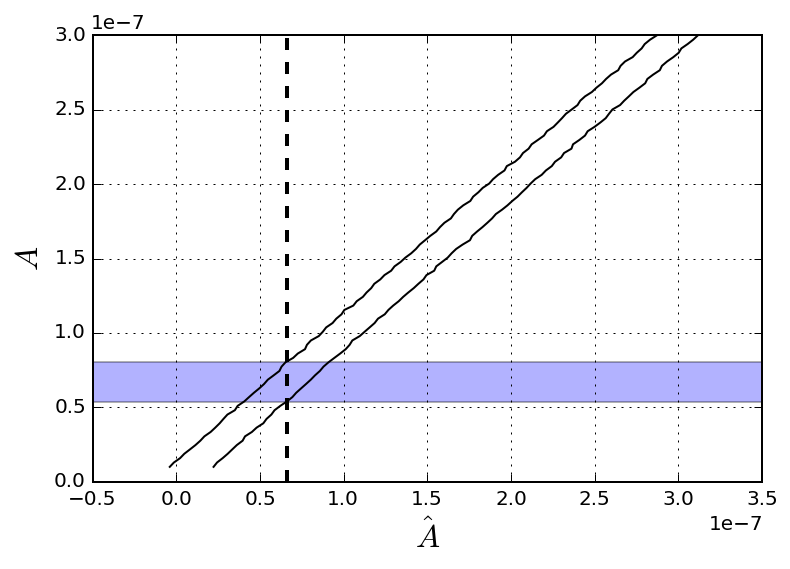

In [10]:
# interpolate to get inverse function for the injected amplitude
# as a function of the confidence regions on Ahat
interplow = interp1d(xmax, Amps)
interphigh = interp1d(xmin, Amps)

plt.plot(xmin, Amps, 'k')
plt.plot(xmax, Amps, 'k')
plt.axvline(Ahat, lw=2, color='k', ls='--')
plt.axhspan(interplow(Ahat), interphigh(Ahat), alpha=0.3)
plt.grid()
plt.xlabel(r'$\hat{A}$', fontsize=16)
plt.ylabel(r'$A$', fontsize=16)

print '1-sigma upper and lower bounds on A: {0} {1}'.format(interplow(Ahat), interphigh(Ahat))
print '1-sigma upper and lower bounds on Ahat: {0} {1}'.format(Ahat-stdAhat, Ahat+stdAhat )

<h3> 1.2.4 Bayesian Credible Interval on Amplitude Parameter</h3>

<p class='lead'>
    As was discussed in the talk and have shown above, Bayesian credible intervals use
    the likelihood function directly to measure our confidence, or degree of belief
    in our measurement of the Amplitude parameter. In practice, this is much less 
    complicated than constructing frequentist confidence intervals. However in
    more complex data analysis problems with many unknown parameters, just constructing
    the full likelihood function is very difficult or at least computatinally demanding.
</p>
<ol class='lead'>
    <li>
        Repeat steps 1-3 from exercise 2.2 to construct the likelihood function for $A$.
    </li>    
    <li>
        Write down an algorithm for computing the Bayesian credible region. You do not have
        to write actual code here unless you feel comfortable. Simply think about how you 
        would set up the problem. <em>Hint:</em> Remember, the desired integral is        
        $$
        \alpha = \int_{\lambda_1}^{\lambda_2}d\lambda\,\, p(\lambda|d)
        $$
        but it can be re-written as        
        $$
        \frac{1-\alpha}{2} = \int_{-\infty}^{\lambda_1}d\lambda\,\, p(\lambda|d)
        $$        
        and        
        $$
        \frac{1+\alpha}{2} = \int^{\infty}_{\lambda_2}d\lambda\,\, p(\lambda|d)
        $$
    </li>    
    <li>
        Use the pre-made function __`confinterval_like()`__ to construct the 1-sigma upper
        and lower bounds on $A$.
    </li>    
    <li>
        Plot the likelihood function vs. $A$ along with the 1-sigma upper and lower bounds, 
        again using the __`plt.plot()`__ and __`plt.axvline()`__ functions.
    </li>
</ol>

1-sigma upper and lower bounds on A: 5.30530530531e-08 7.85785785786e-08
True value of A = 7e-08


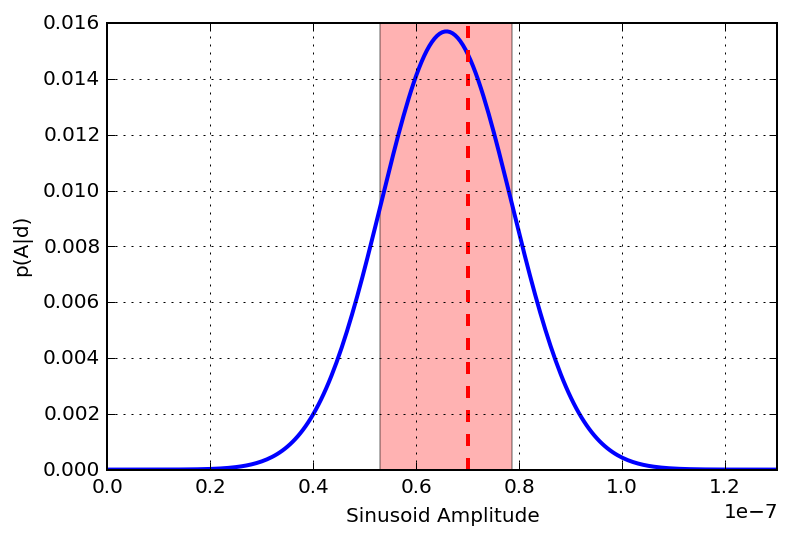

In [11]:
N = 1000
Amps = np.linspace(0, 5e-7, N)
llike = np.zeros(N)
for ii in range(N):
    llike[ii] = LogLikelihood(data, t, Amps[ii], freq, sigma)

like = np.exp(llike)  
xmin, xmax = wu.confinterval_like(like, Amps)
print '1-sigma upper and lower bounds on A: {0} {1}'.format(xmin, xmax)
print 'True value of A = {0}'.format(A)

xmin, xmax = wu.confinterval_like(like, Amps)

plt.plot(Amps, like, lw=2)
plt.axvline(A, color='r', lw=2, ls='--')
plt.axvspan(xmin, xmax, facecolor='r',alpha=0.3)

plt.grid()
plt.xlim(0, 1.3e-7)
plt.xlabel('Sinusoid Amplitude')
plt.ylabel('p(A|d)')

<h2>1.3 Hypothesis Testing: Detecting the Signal</h2>

<p class='lead'>
    Above, when performing parameter estimation we have taken for granted that there was an <em>detectable</em>
    signal in the data. Now we turn to the problem of detection, that is, how can we confidently say that there
    truly is a signal in the data. In the frequentist framework, detection significance is usually based on the
    false alarm probability (sometimes referred to as FAP, I know hilarious right?), that is, the probability 
    that we would (falsely) claim a detection when that data consists of only noise. Henceforth, we refer to this
    noise only case as the <em>null hypothesis</em> and we denote it symbolically as $H_0$. On the other hand we
    refer to the case where the data does contain a signal as the <em>signal hypythesis</em> and we denote it symbolically
    as $H_1$. In the Bayesian framework, we actually compute the <em>evidence</em> for the signal and null hypotheses and
    compare them via the Bayes factor. 
</p>

<p class='lead'>
    In this next section, we will apply these techniques to our simple problem of the sinusoid with unknown amplitude.
</p>

<h3>1.3.1 Frequentist Hypothesis Testing</h3>

<p class='lead'>
    The false alarm probability is defined as   
    $$
    {\rm FAP} = \int_{\hat x}^{\infty} dx\,\, p(x|\lambda,H_0),
    $$    
    where $\hat{x}$ is our measured test statistic, $\lambda$ is the 
    parameter of interest, and $p(x|\lambda,H_0)$ is the pdf of $x$ under the null 
    hypothesis. The dependence on the actual data, comes in the value of $\hat{x}$. Essentially what we are doing
    is we are testing whether our point extimate of $x$ is consistent with a value of $x$ that we would measure if
    the data contains only noise. So to claim a detection, we want to reject the null hypothesis, that is, we want 
    $\hat{x}$ to be <em>inconsistent</em> with the distribution of $x$ under the null hypothesis and the false alarm
    probability quantifies that inconsistency.
</p>

<p class='lead'>
    The value of the false alarm probability that one requires for detection is completely problem dependent. In some
    cases we would be ok with a value of 5% (i.e., we make a false detection 5% of the time). For example, many of the
    social sciences use this value. However, for our purposes we want to be much more confident so we will require 
    $FAP < 10^{-4}$ for a detection, that is, there is a 1 in 10,000 chance that we have made a false detection. It is
    very important to note here that just because we can rule out the null hypothesis with $1-FAP$ confidence, does 
    <em>not</em> mean that the signal hypothesis is true with $1-FAP$ confidence. In fact, frequentist detection methods 
    make no statetments about our confidence in the signal model itself, only that a measurement made under the signal 
    hypothesis is inconsistent with the null hypothesis at the $1-FAP$ level.
</p>

<p class='lead'>
    Now we want to set the value of $\hat{x}$ that would be required for us to have $FAP=10^{-4}$. 
</p>

<ol class='lead'>    
    <li>
        First, we want to construct our detection statistic. The <a href="http://en.wikipedia.org/wiki/Neyman–Pearson_lemma">
        Neyman-Pearson lemma</a> states that the optimal detection statistic is the likelihood ratio. Use our expression for
        the log-likelihood ratio and $\hat{A}$ from exercise 2.1 to construct the maximum likelihood ratio. <em>Hint:</em>
        you should get        
        $$
        \log \Lambda_{\rm max} = \frac{1}{2}\frac{(d|\tilde s)^2}{(\tilde s|\tilde s)}
        $$
    </li>    
    <li>
       As we did for the likelihood ratio. Write a function that reads in the data, the time samples, the frequency 
       of the sine wave and the standard deviation of the noise and returns the maximized log-likelihood ratio.
    </li>    
    <li>
        Now we want to construct the pdf of the maximum log-likelihood ratio under the null hypothesis. As we did
        in exercise 2.3, we want to loop over many realizations of data and compute the max log-likelihood ratio,
        only this time we simulate only noise. Simulate 100000 realizations of data and store the maximum log-likelihood
        values in an array and histogram the results with 50 bins using the __`plt.hist()`__ function.
    </li>    
    <li>
        Now that we have the distribution $p(x|\lambda,H_0)$, we want to determine the value of $\hat{x}=\hat{x}_{\rm thresh}$
        that will give a false alarm probability of $10^{-4}$. We have already build all of the machinery we require to determine
        $\hat{x}_{\rm thresh}$. <em>Hint:</em> If we re-write the FAP integral, we can use the __`confinterval()`__ function
        with the argument onesided=True. Please ask for help if you are stuck here.
        <br/>
        <span style='color:red'>Expert level: This distribution can be computed analytically. Do you know what it is?</span>
    </li>    
    <li>
        Use our original data with a signal to determine if we have made a detection.
    </li>    
</ol>

In [12]:
# maximum likelihood function
def maxLogLikelihood(data, t, f, sigma):
    sig = wu.signal(t, 1, f)
    return wu.innerProduct(data, sig, sigma)**2 / wu.innerProduct(sig, sig, sigma)

In [13]:
# number of realizations
Nreal = 100000

# loop over realizations
maxLike0 = np.zeros(Nreal)
for jj in range(Nreal):
        
    # simulate data
    newx = wu.simData(t, 0, freq, sigma)
    maxLike0[jj] = maxLogLikelihood(newx, t, freq, sigma)

Threshold for detection = 14.2846688676
Maximum likelihood ratio for real data: 1.22999999167


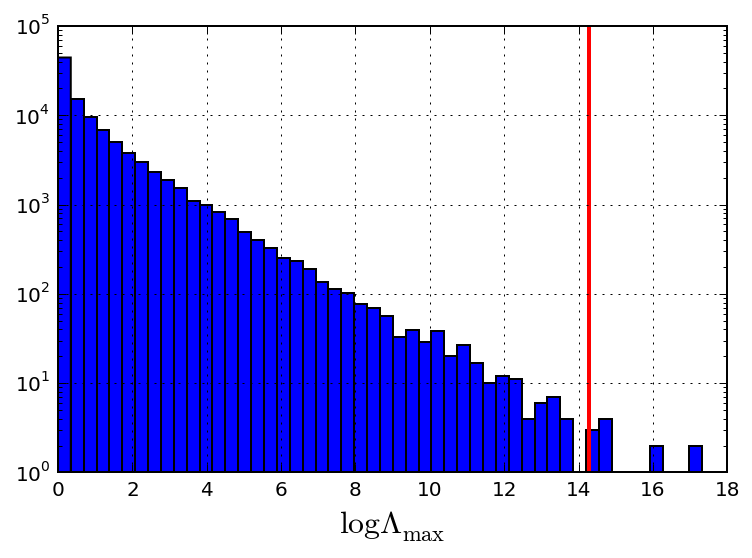

In [163]:
plt.hist(maxLike0, 50, log=True)

FAP=1e-4
tmp, thresh = wu.confinterval(maxLike0, onesided=True, sigma=1-FAP)

plt.axvline(thresh, lw=2, color='r')
plt.xlabel(r'$\log\Lambda_{\rm max}$', fontsize=16)
plt.grid()

print 'Threshold for detection = {0}'.format(thresh)

# compute the maximum log likelihood ratio for the "real" data
maxLike = maxLogLikelihood(data, t, freq, sigma)
print 'Maximum likelihood ratio for real data: {0}'.format(maxLike)

15.1367052282


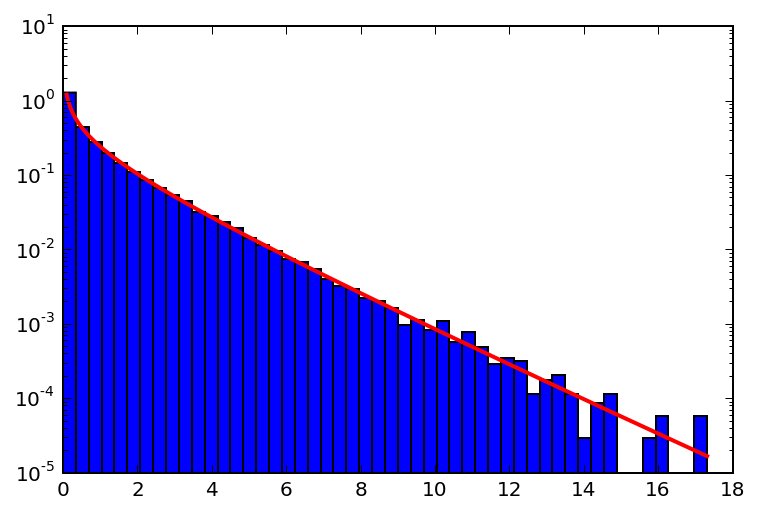

In [164]:
from scipy.stats import chi2

# the distribution is a chi-squared distribution with 1 degree of freedom
rv = chi2(1)
x = np.linspace(0.1, maxLike0.max(), 100000)

plt.semilogy(x, rv.pdf(x), lw=2, color='r')

ifunc = interp1d(rv.cdf(x), x)

print ifunc(1-1e-4)
_ = plt.hist(maxLike0, 50, normed=True, log=True)

#log(1e-4)

<h3>1.3.2 Bayesian Hypothesis Testing</h3>

<p class='lead'>
    When condisering Bayesian parameter estimation, we used Bayes theorem for a <em>single</em> hypothesis. We now use the 
    more general form of Bayes theorem:    
    $$
    p(\lambda,H|d) = \frac{p(d|\lambda,H)p(\lambda,H)}{p(d)},
    $$
    where $p(\lambda,H|d)$ is the probability of the joint posterior of parameters and the hypotheses, $p(d|\lambda,H)$ is the likelihood of the data given a set of parameters and hypotheses, $p(\lambda,H)=p(\lambda|H)p(H)$ is the prior probability on the parameters and hypotheses and $p(d)$ is the probability of the data itself, also known as the evidence. Here we are interested in the evidence:    
    $$
    p(d)=\sum_i\int d\lambda_i\,p(d|\lambda_i,H_i)p(\lambda_i|H_i)p(H_i)= \sum_i p(d|H_i)p(H_i)
    $$
    which is the sum of the marginal likelihoods for different Hypotheses. In some cases, there may be many possible hypotheses, but it is
    always possible to compare different ones. In our case we want to <em>directly</em> calculate the evidence for hypotheses, $H_1$ and $H_0$.
    The bayes factor is defined as the ratio of two marginal likelihoods    
    $$
    B_{10} = \frac{p(d|H_1)}{p(d|H_0)}.
    $$    
    In large parameter spaces, this is notoriously hard to calculate; however, in our case it is trivial since our null 
    hypothesis model has no parameters and our signal model only has 1 parameter we have    
    $$
    B_{10}=\int dA\,\, \Lambda(A|d)p(A)
    $$    
    where $\Lambda(A|d)$ is just the likelihood ratio defined above and $p(A)$ is the prior on $A$, which we take to be constant. 
    For our calculation, we will need to include the prior even though it is a constant. You can analytically find the normalizing
    constant by integrating $p(A)=C$ over the range of $A$ (which is $[0,5\times10^{-7}]$ if using the same as exercise 2.2) and 
    setting it equal to 1. That is, we require    
    $$
    \int dA\,\, p(A) = 1
    $$
</p>

<ol class='lead'>
    <li>
        Loop over 1000 amplitude values and compute the log likelihood just like in exercise 2.2. Once you have the log-likelihood ratio 
        at each amplitude value you can exponentiate it to obtain the likelihood itself.
    </li>    
    <li>
        Use the likelihood values to compute the bayes factor. Remember we can just use a block integral        
        $$
        \int dA\,\, \Lambda(A|d) \approx \sum_i\Lambda(A_i|d) \Delta A.
        $$        
        The value of the Bayes factor that is normally considered decisive evidence for model $H_1$ over model $H_0$ is 100. This 
        values comes from the so-called <a href="http://en.wikipedia.org/wiki/Bayes_factor#Interpretation">Jeffreys' scale</a>. For
        our purposes here we will follow this scale but in real data analysis applications is is an open problem as to which value 
        one would truly consider decisive, say for claiming the detection of GWs. One could implement a hybrid frequentist-Bayesian
        method where the Bayes factor is used as our test statistic and we can set corresponding FAPs and thresholds for detection.
    </li>
</ol>

In [16]:
N = 1000
Amps = np.linspace(0, 5e-7, N)
dA = Amps[1]-Amps[0]
llike = np.zeros(N)
for ii in range(N):
    llike[ii] = LogLikelihood(data, t, Amps[ii], freq, sigma)

like = np.exp(llike)  

# bayes factor
B = np.sum(like)/Amps.max()*dA
print 'Bayes factor = {0}'.format(B)


Bayes factor = 43200.9889284


<h4>1.3.2.1 Occam Penalty</h4>

<p class='lead'>
    In hypothesis testing we generally want to choose the simplest model if it provides a good fit to the data. In essence, 
    we need to weigh the "goodnes of fit" versus the simplicity of the model. For example, we could use a free parameter for 
    every data point, then our model would fit the data perfectly but this model would have hundreds of parameters, versus just
    one for our sinusoid model. The bayes factor automatically incorporates this parsimony through the integration of the posterior,
    which contains our prior distribution. 
</p>

<ol class='lead'>
    <li>
        We can see this automatic parsimony by choosing a larger prior range on $A$ in the above calculation of the Bayes factor. 
        Repeat the calculation but now create the amplitude vector going up to $5\times 10^{-6}$. <em>Hint:</em> Remember to 
        recalculate the normalization of the prior.
    </li>
</ol>

In [17]:
N = 1000
Amps = np.linspace(0, 5e-6, N)
dA = Amps[1]-Amps[0]
llike = np.zeros(N)
for ii in range(N):
    llike[ii] = LogLikelihood(data, t, Amps[ii], freq, sigma)

like = np.exp(llike)  

# bayes factor
B = np.sum(like)/Amps.max()*dA
print 'Bayes factor = {0}'.format(B)

Bayes factor = 4320.09918458


# 2 Data analysis of unkown sinusoid in unknown white noise

<p class='lead'>
    Here you will perform a similar Bayesian Analysis to the one above but we will be expanding the
    number of free parameters from a single unknown amplitude to an unknown, amplitude, frequency, 
    and phase of the sinusoid plus an unknown white noise level. This will allow us to introduce
    multi-parameter likelihoods and Markov Chain Monte-Carlo. Real GW analyses usually have tens to
    hundreds of free parameters; however, for this exercise 4 free parameters will give you a feel for
    how to run more complex models.
</p>

## 2.1 Creating the Model Class

In [18]:
class Model(object):
    
    def __init__(self, x, t, pmin=[-9, -9, 0, -9], 
                 pmax=[-6, -7, 2*np.pi, -6]):
        """
        Model class contains calls to log-likelihood and
        log-prior functions. All calls to log-likelihood
        and log-prior functions take in parameter array
        in the order:
        
        0: log10 Amplitude [s]
        1: log10 frequency [Hz]
        2: phase [radian]
        3: log10 sigma [s]
        
        :param x: Data vector
        :param t: Times at which data is taken
        :param pmin: Minimum values of model parameters
        :param pmax: Maximum values of model parameters
        """
        
        self.x = x
        self.t = t  
        self.pmin = np.array(pmin)
        self.pmax = np.array(pmax)
    
    def get_loglike(self, pars):

        s = wu.signal(self.t, 10**pars[0], 10**pars[1], pars[2])
        sigma = 10**pars[-1]
        diff = self.x - s
    
        loglike = -0.5 * np.sum(np.log(2*np.pi*sigma**2) + diff**2/sigma**2)
    
        return loglike
    
    def get_logprior(self, pars):

        prior = 0
        if np.all(pars > self.pmin) and np.all(pars < self.pmax):
            prior += -np.sum(np.log(self.pmax-self.pmin))
        else:
            prior = -np.inf

        return prior

## 2.2 Set up data and model

<p class='lead'>
    Set up a data set exactly as above in section 1.1 but with phase = 1.5.
    You can do this by using the ```phi``` keyword argument to ```wu.simData```
    and ```wu.signal```.
    
    As you go through the next steps in sampling you can simulated different data
    sets with different parameters just to get a feel for things.
</p>

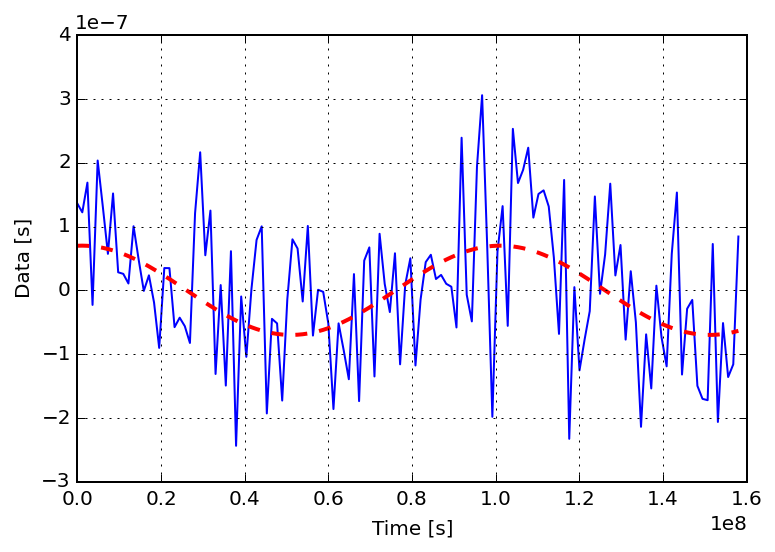

In [149]:
# simulated data
freq = 1e-8
sigma = 1e-7
t = np.linspace(0, 3.16e7*5, 130)
A = 7e-8
phase = 1.5

# call function to simulate data
data = wu.simData(t, A, freq, sigma, phi=phase)

# can also get signal individually
sig = wu.signal(t, A, freq, phi=phase)

# plot
plt.plot(t, data)
plt.plot(t, sig, lw=2, color='r', ls='--')
plt.xlabel('Time [s]')
plt.ylabel('Data [s]')
plt.grid()

In [150]:
# setup model object
model = Model(data, t)

## 2.3 MCMC Sampling

<p class='lead'>
    Here you will use a simple MCMC sampler to explore this 4-d parameter
    space. We have already provided the sampler via ```smcmc.SimplerMCMC```,
    but you can explore it more [here](https://github.com/vhaasteren/cit-busyweek/blob/master/day1/day1_solutions.ipynb).
</p>

<ol class='lead'>
    <li> Draw initial search parameters from the prior using ```np.random.uniform```</li>
    <li> Set jump ```sigmas``` to 0.05</li>
    <li> Initialize sampler with loglike and logprior functions from your model object.</li>
    <li> Run sampler for 100000 steps. </li>
</ol>


In [151]:
# initial parameters
N = 100000
p0 = np.random.uniform(model.pmin, model.pmax)

sigmas = 0.05
sampler = smcmc.SimpleMCMC(model.get_loglike, model.get_logprior, sigmas)
sampler.sample(p0, N)

Finished 99.9 percent. Acceptance Rate: 20.9349

### 2.3.1 Visualizing sampler output

<p class='lead'>
    Here you will perform some standard visualizations for analyzing MCMC output.
    These plots are criticial to checking convergence of the MCMC and for visualizing
    parameter covariances.   
</p>

<ol class='lead'>
    <li> Set burn-in to be 25% of chain length</li>
    <li> Plot the log posterior, ```sampler.lnprob``` vs iteration number. 
    This should be stable and not growing with iteration number. </li>
    <li> Plot the parameter samples vs. iteration number for each of the 4 parameters. Again these should be stable and sampling around a centeral value.</li>
    <li> Use the ```corner``` function to make a triangle plot of the 4 search parameters. Also, plot the injected parameters and the 1-sigma quantiles. See [here](https://github.com/dfm/corner.py) for help.</li>
    <li> What can you say about the results of this run. Are the injections consistent with the posterior? What parameters are correlated?</li>
</ol>

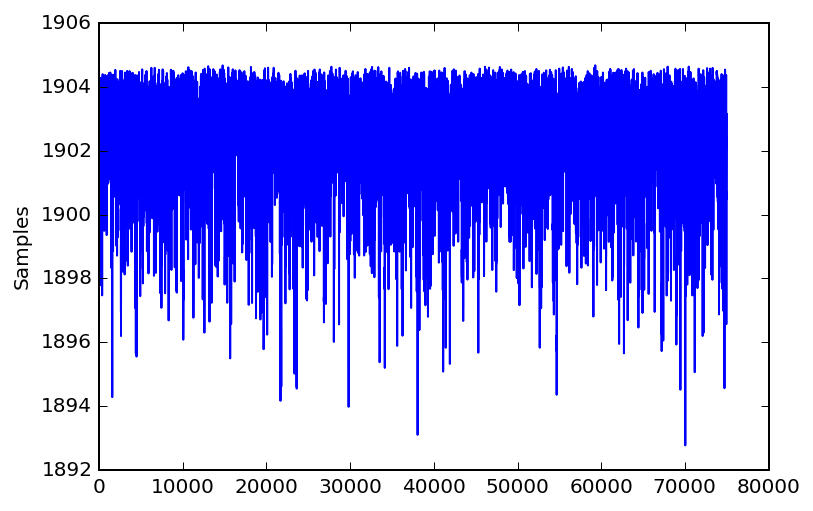

In [152]:
# set burn-in to be 25% of chain
burn = int(0.25 * sampler.chain.shape[0])

# plot log-posterior
plt.plot(sampler.lnprob[burn:])
plt.ylabel('log-posterior')
plt.ylabel('Samples')

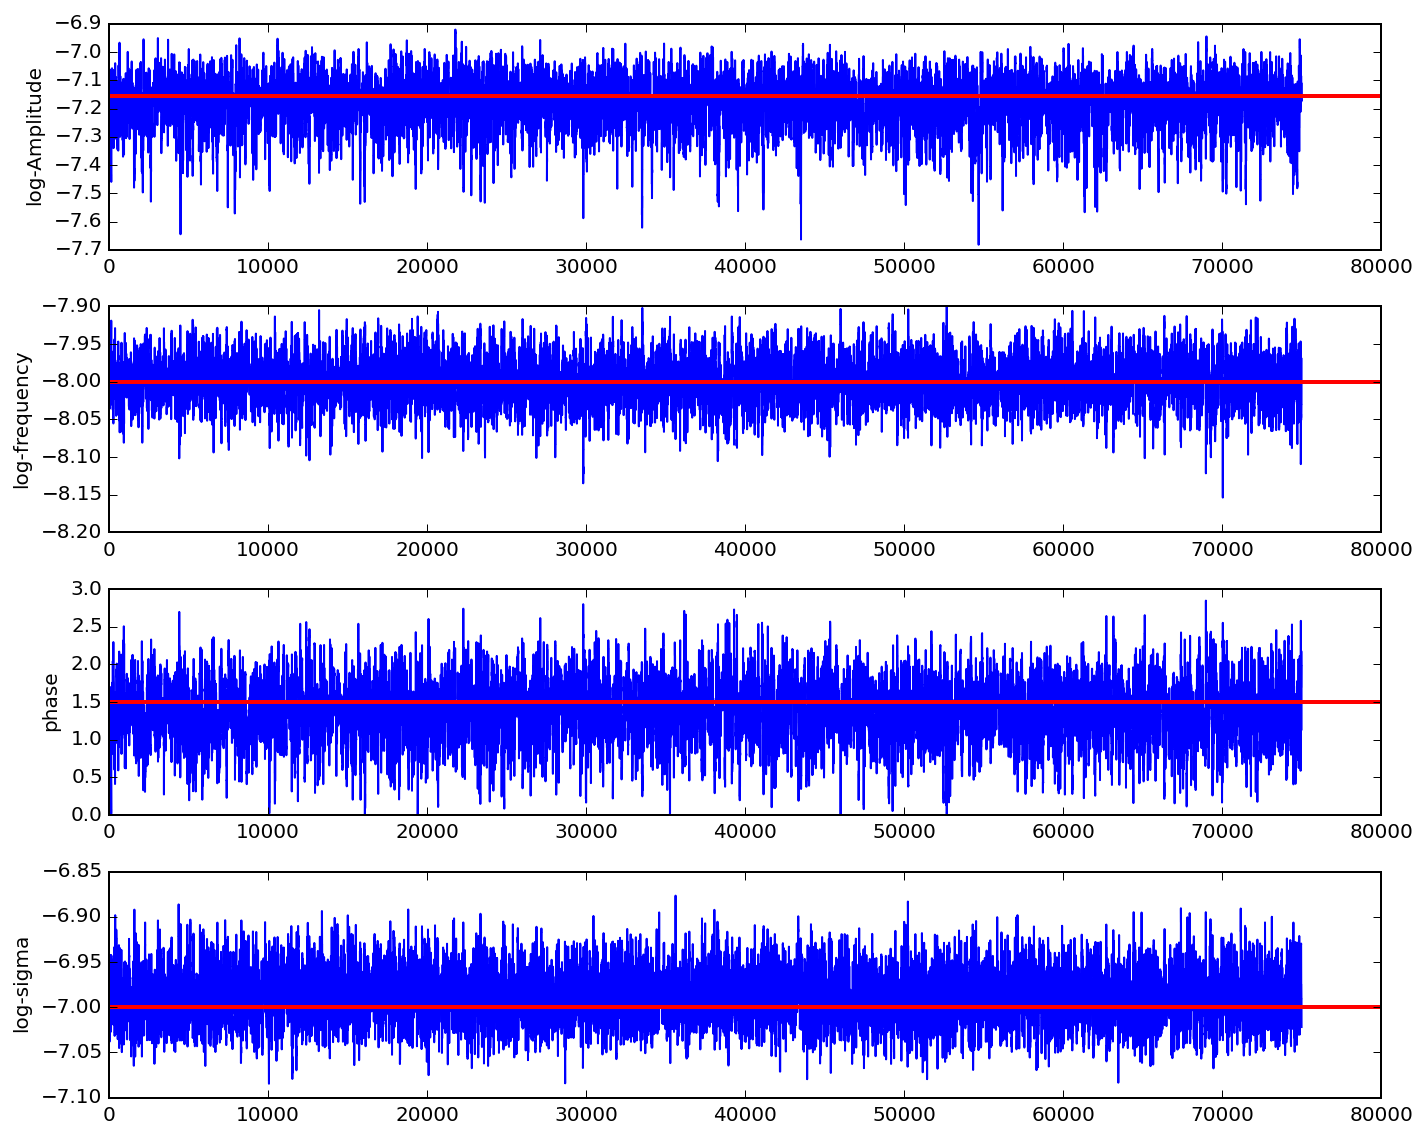

In [153]:
# make list of parameter labels
pars = ['log-Amplitude', 'log-frequency', 'phase', 'log-sigma']

# make list of injected parameters
inj = [np.log10(A), np.log10(freq), phase, np.log10(sigma)]

# plot chain traces for 4 parameters
plt.figure(figsize=(10,8))
for ii in range(4):
    plt.subplot(4, 1, ii+1)
    plt.plot(sampler.chain[burn:,ii])
    plt.axhline(inj[ii], color='r', lw=2)
    plt.ylabel(pars[ii])

plt.tight_layout()

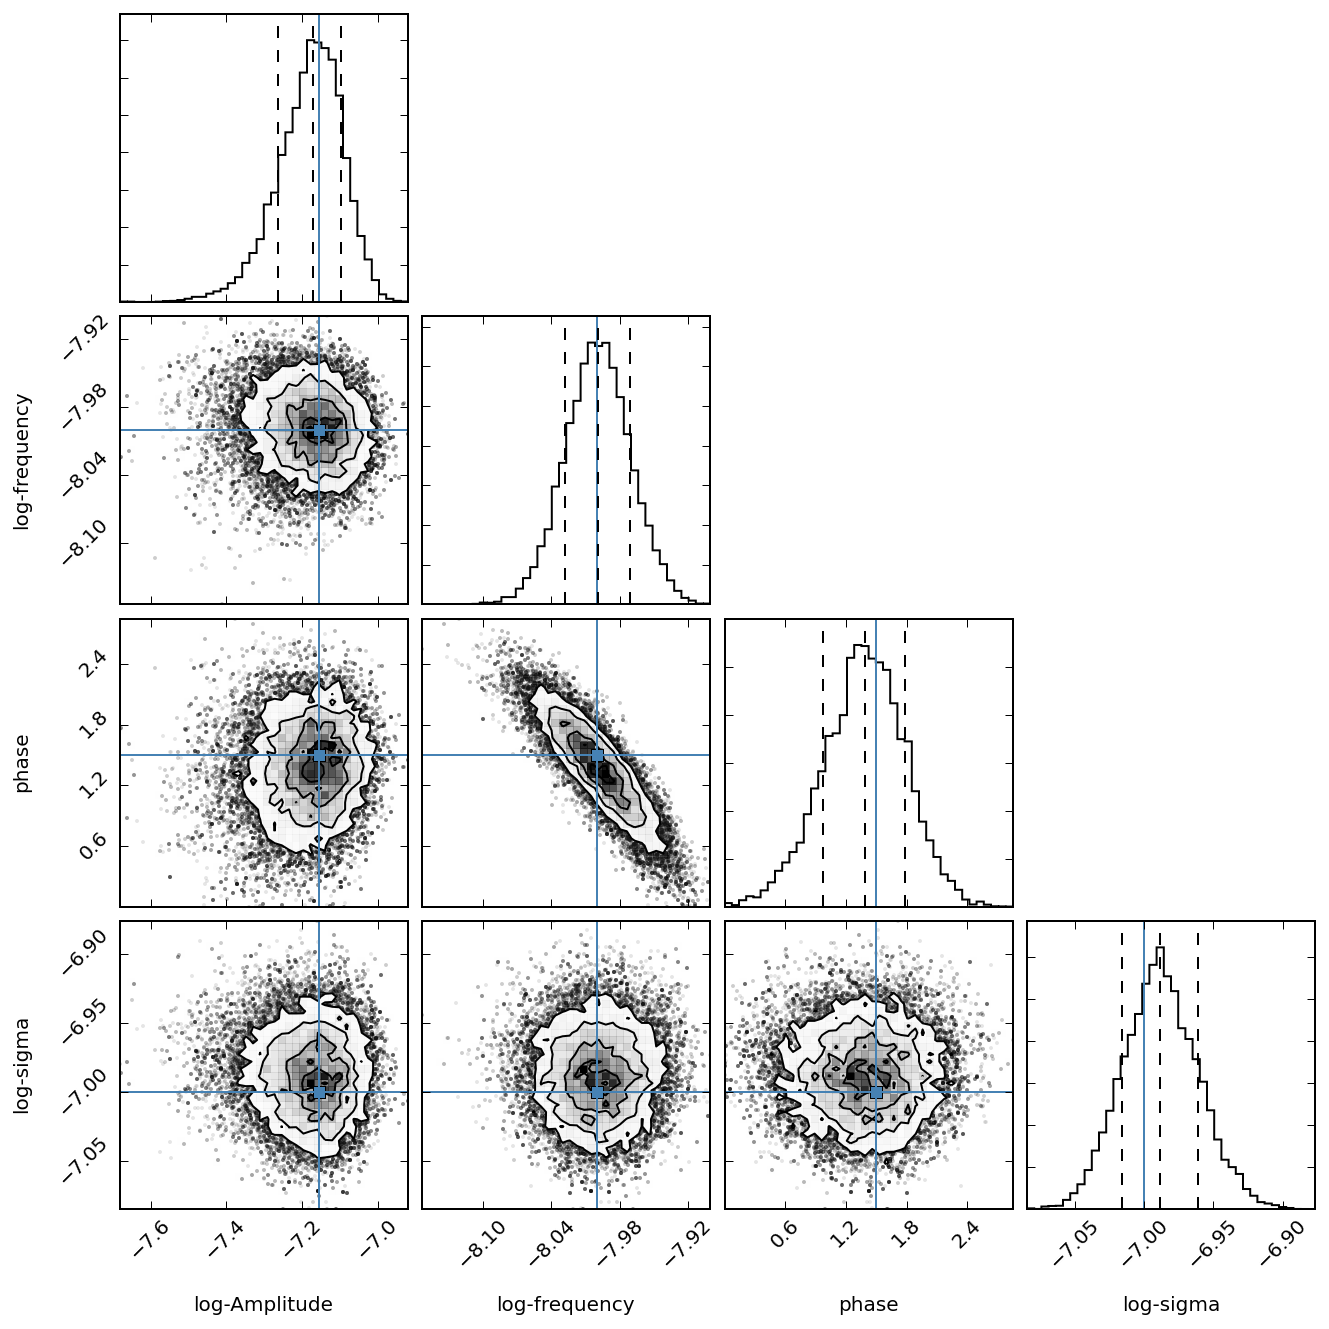

In [154]:
_ = corner(sampler.chain[burn:,:], bins=40, truths=inj, labels=pars, quantiles=[0.16, 0.5, 0.84])

## 2.4 Computing Bayesian Evidence via Nested Sampling

<p class='lead'>
    Here we will be computing the Bayes factor between the signal model
    (i.e. signal + noise) and the noise model (i.e. signal=0 + noise). 
    Previously computing Bayes factor was easy because we simply could
    integrate a 1-d function. Now, our posterior is 4-d and the integral
    becomes much harder. There are several ways of computing the Bayesian 
    Evidence such as Nested Sampling, Reversible Jump MCMC, Thermodynamic 
    integration and others ([see this paper for a good review](http://arxiv.org/abs/0704.1808)).
    <br><br>
    Here we will be using a nested sampling implementation called [Nestle](http://kbarbary.github.io/nestle/).
    We are using this mostly for simplicity as nested sampling is one of the easiest methods for
    computing the Bayesian evidence in relatively small parameter spaces (i.e. < 50 parameters). 
    <br><br>
    In the following section, we will modify the model class and compute the Bayes factor!
</p>

### 2.4.1 Modify Model class for Nestle and model selection

<p class='lead'>
    To run Nestle and to run our noise only model, we will have to
    make some modifications to the Model class.
    
    <ol class=lead>
        <li>Add extra option to initialize Model class with a specifice model. 
        full=signal+noise and null=noise only</li>
        <li> Add an if statement to ```get_loglike``` to check for the model
        and return the correct likelihood.</li>
        <li>Define an extra function ```get_prior_transform``` to compute the prior
        transform found [here](http://kbarbary.github.io/nestle/prior.html)</li>
    </ol>
</p>

In [155]:
class Model(object):
    
    def __init__(self, x, t, pmin=[-9, -9, 0, -9], 
                 pmax=[-6, -7, 2*np.pi, -6], model='full'):
        """
        Model class contains calls to log-likelihood and
        log-prior functions. All calls to log-likelihood
        and log-prior functions take in parameter array
        in the order:
        
        0: log10 Amplitude [s]
        1: log10 frequency [Hz]
        2: phase [radian]
        3: log10 sigma [s]
        
        if using full model and 
        
        0: log10 sigma[s]
        
        if using null model
        
        :param x: Data vector
        :param t: Times at which data is taken
        :param pmin: Minimum values of model parameters
        :param pmax: Maximum values of model parameters
        :param model: Model type [full, null]
        """
        
        self.x = x
        self.t = t  
        self.pmin = np.array(pmin)
        self.pmax = np.array(pmax)
        self.model = model
    
    def get_loglike(self, pars):
        
        if self.model == 'full':
            s = wu.signal(self.t, 10**pars[0], 10**pars[1], pars[2])
            sigma = 10**pars[-1]
            diff = self.x - s
        elif self.model == 'null':
            sigma = 10**pars[0]
            diff = self.x
    
        loglike = -0.5 * np.sum(np.log(2*np.pi*sigma**2) + diff**2/sigma**2)
    
        return loglike
    
    def get_logprior(self, pars):

        prior = 0
        if np.all(pars > self.pmin) and np.all(pars < self.pmax):
            prior += -np.sum(np.log(self.pmax-self.pmin))
        else:
            prior = -np.inf

        return prior
    
    def get_prior_transform(self, cube):
        
        return (self.pmax - self.pmin) * cube + self.pmin

### 2.4.2 Run Nested sampling on signal + noise model

<ol class='lead'>
    <li> Initialize full model (i.e. just like before)</li>
    <li> Run Nestle with ```nestle.sample``` using 300 live points and ```dlogz```=0.1</li>
    <li> Print the summary with ```print result.summary()```</li>
    <li> Inspect posterior with ```corner``` as above. However, this time you will
    have to add a a few extra arguments such as ```weights=result.weights``` and 
    ```range=[0.997, 0.997, 0.997, 0.997]```. The weights are due to the fact that Nested
    Sampling collects samples different than MCMC and the range is so that we zoom in on the 
    high probability regions.</li>
    <li>Do these posteriors seem consistent with the MCMC?</li>
</ol>

In [156]:
# initialize model
fullmodel = Model(data, t)

In [157]:
# run Nestle
ndim = 4
fullresult = nestle.sample(fullmodel.get_loglike, fullmodel.get_prior_transform, ndim, 
                       npoints=300, dlogz=0.1)
print fullresult.summary()

niter: 4352
ncall: 82755
nsamples: 4652
logz: 1897.233 +/-  0.184
h: 10.109


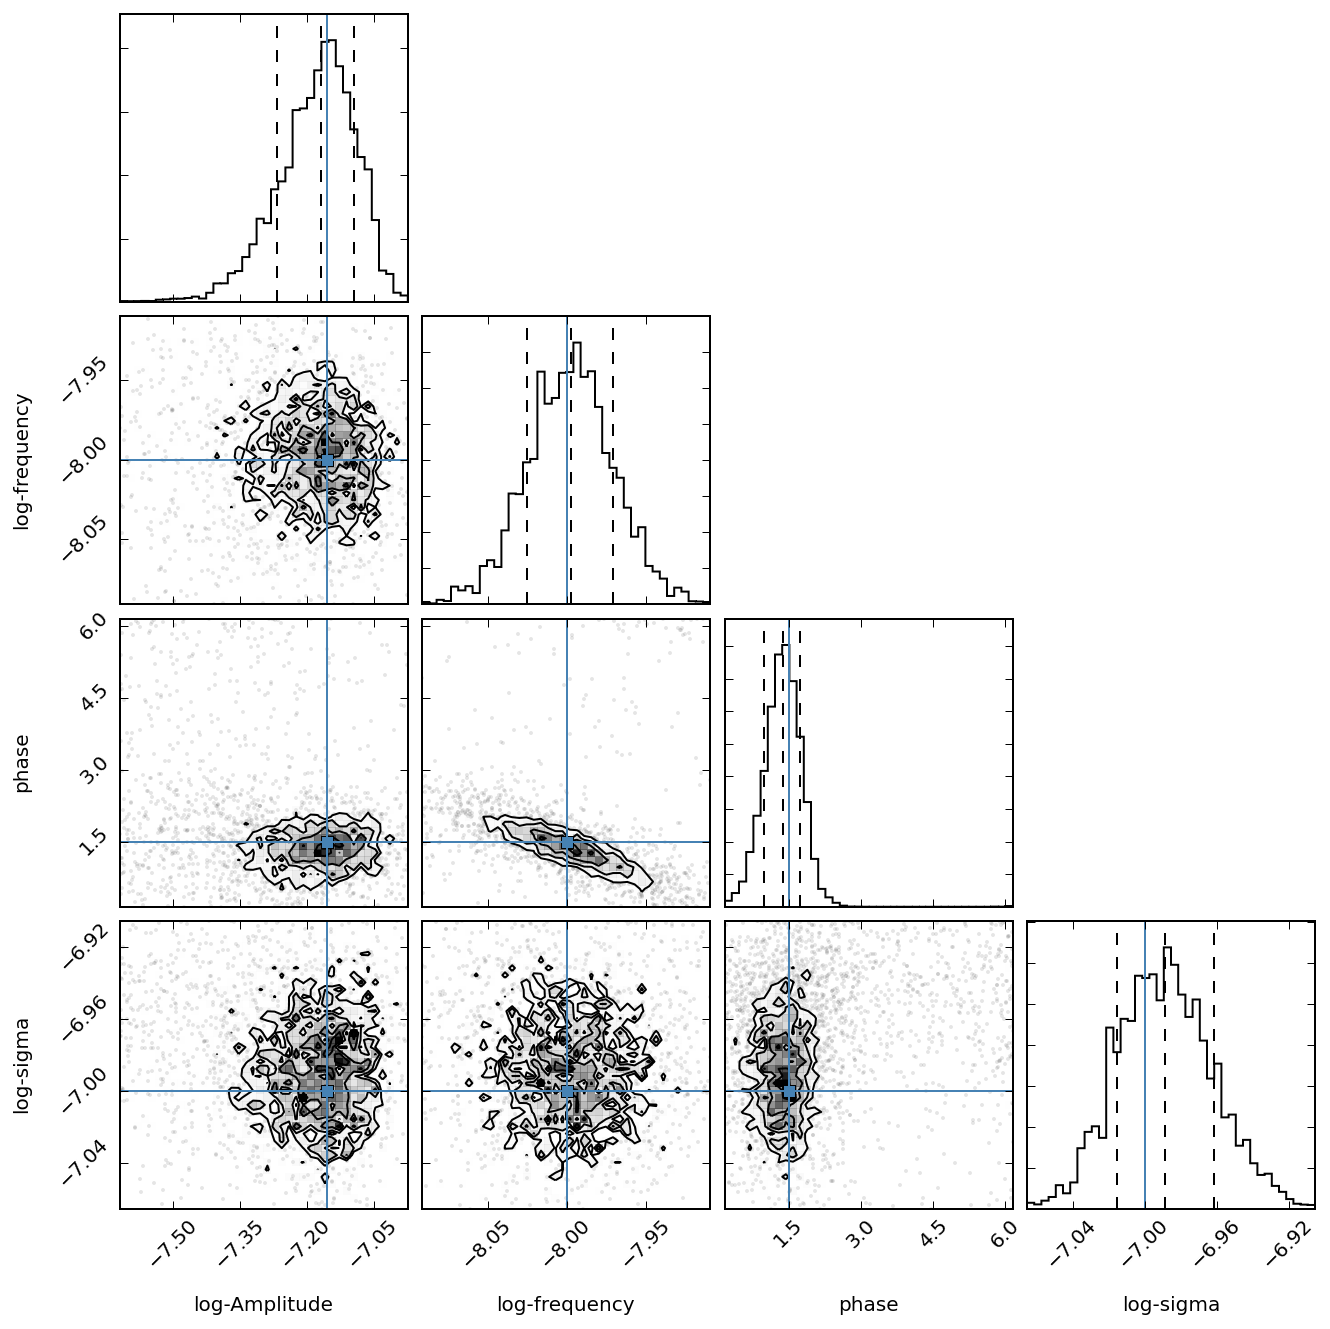

In [158]:
_ = corner(fullresult.samples, bins=40, truths=inj, labels=pars, quantiles=[0.16, 0.5, 0.84], 
           weights=fullresult.weights , range=[0.997, 0.997, 0.997, 0.997])

### 2.4.3 Run Nestle on null model

<ol class='lead'>
    <li> Initilize the null model. You will have to give the initialization
    ```pmin=[-9], pmax=[-6], model='null'``` so that it knows to use the noise
    only model.</li>
    <li> Run Nestle with the same settings (remember to set ```ndim```=1 though)</li>
    <li>Compute the log Bayes factor by computing the difference in logz between the two
    models.</li>
    <li>How significant is the result based on the Bayes factor interpretations mentioned in 
    problem 1.3.2?</li>
</ol>

In [159]:
# initialize model
nullmodel = Model(data, t, pmin=[-9], pmax=[-6], model='null')

In [160]:
# run Nestle
ndim = 1
nullresult = nestle.sample(nullmodel.get_loglike, nullmodel.get_prior_transform, ndim, 
                       npoints=300, dlogz=0.1)
print nullresult.summary()

niter: 1889
ncall: 2878
nsamples: 2189
logz: 1890.287 +/-  0.106
h:  3.385


In [161]:
print 'ln Bayes Factor = {0}'.format(fullresult.logz - nullresult.logz)

ln Bayes Factor = 6.94652393205


### 2.4.4 Other injections

<p class='lead'>
    Repeat all of this section with injections with sinusoid amplitudes of 
    5, 15, and 30 ns. You can just change the amplitude above and re-evaluate the cells.

</p>